<a href="https://colab.research.google.com/github/siddish-reddy/A-to-Z-Resources-for-Students/blob/master/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gender, Age, Ethnicity prediction from images

## Loading Modules and models

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
from fastai.vision import *
from fastai import __version__ as fastai_version
print(fastai_version)
import types
import cv2 as cv
import os
import math
import time
from time import sleep

1.0.57


In [1]:
!pip install floyd-cli

     |████████████████████████████████| 71kB 2.8MB/s 
     |████████████████████████████████| 61kB 23.1MB/s 
     |████████████████████████████████| 51kB 21.4MB/s 
     |████████████████████████████████| 286kB 56.9MB/s 
  Created wheel for floyd-cli: filename=floyd_cli-0.11.17-cp36-none-any.whl size=54289 sha256=1cd708fa1f6320e127d4fddd3134e2ad9b72bfcfe683c2aa431fd26b9497ca6d
  Stored in directory: /root/.cache/pip/wheels/50/a4/5a/da0d4817a16af0c2d382a7a3bd8c6270dd7414705a5323c1ab
  Created wheel for clint: filename=clint-0.5.1-cp36-none-any.whl size=34448 sha256=1893408787ab26a6bd9c030b20825e4574e15589e7b5cc944bbb9a3da82d1a06
  Stored in directory: /root/.cache/pip/wheels/4f/e9/45/223565e5b1a4b09e12c6de6f8ba7c2c0e9127dec17cf830f83
  Created wheel for args: filename=args-0.1.0-cp36-none-any.whl size=3320 sha256=9d08788ba13d26874cb110bb542024ddd18deafa0b3f6189a62584504f018907
  Stored in directory: /root/.cache/pip/wheels/58/54/ea/d995d18af68c057eb76b87b02c92bc66ac34d360ef141780f4
Succe

In [0]:
from google.colab.patches import cv2_imshow as imshow

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp drive/'My Drive'/'Colab Notebooks'/trained_weights.pkl face.pkl

In [0]:
!cp drive/'My Drive'/'Colab Notebooks'/haarcascade_frontalface_alt.xml haarcascade_frontalface_alt.xml

In [0]:
!cp -R drive/'My Drive'/'Colab Notebooks'/age_gender_net age_gender_net/

In [2]:
np.random.seed(int(time.time()))

NameError: ignored

## Helper functions to load and inference from model

In [0]:
def mt_load_learner(path:PathOrStr, file:PathLikeOrBinaryStream='export.pkl', test:ItemList=None, **db_kwargs):
  
    source = Path(path)/file if is_pathlike(file) else file
    state = torch.load(source, map_location='cpu') if defaults.device == torch.device('cpu') else torch.load(source)
    model = state.pop('model')
    src = MultitaskLabelLists.load_state(path, state.pop('data'))

    if test is not None: src.add_test(test)
    data = src.databunch(**db_kwargs)
    data.single_ds.y.mt_classes = src.mt_classes
    data.single_ds.y.mt_lengths = src.mt_lengths
    data.single_ds.y.mt_types = src.mt_types
    data.single_ds.y.mt_names = src.mt_names
    
    cb_state = state.pop('cb_state')
    clas_func = state.pop('cls')
    res = clas_func(data, model, **state)
    res.callback_fns = state['callback_fns'] #to avoid duplicates
    res.callbacks = [load_callback(c,s, res) for c,s in cb_state.items()]
    return res
def multitask_loss(inputs_concat, *targets, **kwargs):
  mt_lengths, mt_types = data.mt_lengths, data.mt_types
  start = 0
  
  loss_size = targets[0].shape[0] if kwargs.get('reduction') == 'none' else 1
  losses = torch.zeros([loss_size]).cuda()
  
  for i, length in enumerate(data.mt_lengths):
      
      input = inputs_concat[:,start: start + length]
      target = targets[i]
      
      input, target = _clean_nan_values(input, target, data.mt_types[i], data.mt_classes[i])
      
      if data.mt_types[i] == CategoryList:
          losses += CrossEntropyFlat(**kwargs)(input, target).cuda()
      elif issubclass(data.mt_types[i], FloatList):
          losses += MSELossFlat(**kwargs)(input, target).cuda()
      start += length
  
  if kwargs.get('reduction') == 'none':
      return losses
  return losses.sum()
class MultitaskAverageMetric(AverageMetric):
    def __init__(self, func, name=None):
        super().__init__(func)
        self.name = name # subclass uses this attribute in the __repr__ method.

def _mt_parametrable_metric(inputs, *targets, func, start=0, length=1, i=0):
    input = inputs[:,start: start + length]
    target = targets[i]

    _remove_nan_values(input, target, data.mt_types[i], data.mt_classes[i])
    
    if func.__name__ == 'root_mean_squared_error':
        processor = listify(learn.data.y.processor)
        input = processor[0].procs[i][0].unprocess_one(input) 
        target = processor[0].procs[i][0].unprocess_one(target.float()) 
    return func(input, target)

def _format_metric_name(field_name, metric_func):
    return f"{field_name} {metric_func.__name__.replace('root_mean_squared_error', 'RMSE')}"

def mt_metrics_generator(multitask_project, mt_lengths):
    metrics = []
    start = 0
    for i, ((name, task), length) in enumerate(zip(multitask_project.items(), mt_lengths)):
        metric_func = task.get('metric')
        if metric_func:
            partial_metric = partial(_mt_parametrable_metric, start=start, length=length, i=i, func=metric_func)
            metrics.append(MultitaskAverageMetric(partial_metric, _format_metric_name(name,metric_func)))
        start += length
    return metrics

In [0]:
# Monkey patch FloatItem with a better default string formatting.
def float_str(self):
    return "{:.4g}".format(self.obj)
FloatItem.__str__ = float_str

class MultitaskItem(MixedItem):    
    def __init__(self, *args, mt_names=None, **kwargs):
        super().__init__(*args,**kwargs)
        self.mt_names = mt_names
    
    def __repr__(self):
        return '|'.join([f'{self.mt_names[i]}:{item}' for i, item in enumerate(self.obj)])

class MultitaskItemList(MixedItemList):
    
    def __init__(self, *args, mt_names=None, **kwargs):
        super().__init__(*args,**kwargs)
        self.mt_classes = [getattr(il, 'classes', None) for il in self.item_lists]
        self.mt_types = [type(il) for il in self.item_lists]
        self.mt_lengths = [len(i) if i else 1 for i in self.mt_classes]
        self.mt_names = mt_names
        
    def get(self, i):
        return MultitaskItem([il.get(i) for il in self.item_lists], mt_names=self.mt_names)
    
    def reconstruct(self, t_list):
        items = []
        t_list = self.unprocess_one(t_list)
        for i,t in enumerate(t_list):
            if self.mt_types[i] == CategoryList:
                items.append(Category(t, self.mt_classes[i][t]))
            elif issubclass(self.mt_types[i], FloatList):
                items.append(FloatItem(t))
        return MultitaskItem(items, mt_names=self.mt_names)
    
    def analyze_pred(self, pred, thresh:float=0.5):         
        predictions = []
        start = 0
        for length, mt_type in zip(self.mt_lengths, self.mt_types):
            if mt_type == CategoryList:
                predictions.append(pred[start: start + length].argmax())
            elif issubclass(mt_type, FloatList):
                predictions.append(pred[start: start + length][0])
            start += length
        return predictions

    def unprocess_one(self, item, processor=None):
        if processor is not None: self.processor = processor
        self.processor = listify(self.processor)
        for p in self.processor: 
            item = _processor_unprocess_one(p, item)
        return item

def _processor_unprocess_one(self, item:Any):
    res = []
    for procs, i in zip(self.procs, item):
        for p in procs: 
            if hasattr(p, 'unprocess_one'):
                i = p.unprocess_one(i)
        res.append(i)
    return res

In [0]:
class MultitaskLabelList(LabelList):
    def get_state(self, **kwargs):
        kwargs.update({
            'mt_classes': self.mt_classes,
            'mt_types': self.mt_types,
            'mt_lengths': self.mt_lengths,
            'mt_names': self.mt_names
        })
        return super().get_state(**kwargs)

    @classmethod
    def load_state(cls, path:PathOrStr, state:dict) -> 'LabelList':
        res = super().load_state(path, state)
        res.mt_classes = state['mt_classes']
        res.mt_types = state['mt_types']
        res.mt_lengths = state['mt_lengths']
        res.mt_names = state['mt_names']
        return res
    
class MultitaskLabelLists(LabelLists):
    @classmethod
    def load_state(cls, path:PathOrStr, state:dict):
        path = Path(path)
        train_ds = MultitaskLabelList.load_state(path, state)
        valid_ds = MultitaskLabelList.load_state(path, state)
        return MultitaskLabelLists(path, train=train_ds, valid=valid_ds)
class NormalizationProcessor(PreProcessor):
    "`PreProcessor` that computes mean and std from `ds.items` and normalizes them."
    def __init__(self, ds:ItemList):        
        self.compute_stats(ds)
        
        self.state_attrs = ['mean', 'std']
        
    def compute_stats(self, ds:ItemList):
        items = ds.items[~np.isnan(ds.items)]
        self.mean = items.mean()
        self.std = items.std()

    def process_one(self,item):
        if isinstance(item, EmptyLabel): return item
        return (item - self.mean) / self.std
    
    def unprocess_one(self, item):
        if isinstance(item, EmptyLabel): return item
        return item * self.std + self.mean
        
    def process(self, ds):
        if self.mean is None: 
            self.compute_stats(ds)
        ds.mean = self.mean
        ds.std = self.std
        super().process(ds)

    def __getstate__(self): 
        return {n:getattr(self,n) for n in self.state_attrs}

    def __setstate__(self, state:dict):
        self.state_attrs = state.keys()
        for n in state.keys():
            setattr(self, n, state[n])
                
class NormalizedFloatList(FloatList):
    _processor = NormalizationProcessor

In [0]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  display(Image(filename))
  return filename

In [0]:
def np2Image(frame):
  return vision.image.Image(pil2tensor(frame, np.float32).div_(255))

## Inference

In [0]:
Genders = ['male', 'female']
Ages = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
Ages = [1, 5, 10, 17, 29, 40, 50, 60]
def origAgeLabel(age):
    if age<20:
      return 'Age_below20'
    if age<30:
      return 'Age_20_30'
    if age<40:
      return 'Age_30_40'
    if age<50:
      return 'Age_40_50'
    else:
      return 'Age_above50'

def findFaces(img, confidence_threshold=0.7):
    # Get original width and height
    height = img.shape[0]
    width = img.shape[1]
    
    face_boxes = []

    # Get grayscale image
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Detect faces
    detections = face_cascade.detectMultiScale(gray, scaleFactor=1.07, minNeighbors=1)
    
    for (x, y, w, h) in detections:
        padding_h = int(math.floor(0.5 + h * face_padding_ratio))
        padding_w = int(math.floor(0.5 + w * face_padding_ratio))
        x1, y1 = max(0, x - padding_w), max(0, y - padding_h)
        x2, y2 = min(x + w + padding_w, width - 1), min(y + h + padding_h, height - 1)
        face_boxes.append([x1, y1, x2, y2])
    
    return face_boxes


def collectFaces(frame, face_boxes):
    faces = []
    height_orig, width_orig, _ = frame.shape
    # Process faces
    for i, box_orig in enumerate(face_boxes):
        face_bgr = frame[
            max(0, box_orig[1]):min(box_orig[3] + 1, height_orig - 1),
            max(0, box_orig[0]):min(box_orig[2] + 1, width_orig - 1),
            :
        ]
        faces.append(face_bgr)
    return faces


def predictAgeGender(faces):
    # Convert faces to N,3,227,227 blob
    blob = cv.dnn.blobFromImages(faces, scalefactor=1.0, size=(227, 227),
                                  mean=(78.4263377603, 87.7689143744, 114.895847746), swapRB=False)
    # Predict gender
    gender_net.setInput(blob)
    genders = gender_net.forward()
    # Predict age
    age_net.setInput(blob)
    ages = age_net.forward()
    ethnicities = []
    ages_res = []
    genders_res = []
    for (i, face) in enumerate(faces):
      preds = model.predict(np2Image(face))
      probs = preds[1]
      res = str(preds[0]).split('|')
      ethnicity = res[1].split(':')[1]
      age = origAgeLabel((float(res[2].split(':')[1])-4+ Ages[ages[i].argmax()])/2)
      gender = Genders[genders[i].argmax()]
      if gender!= res[0].split(':')[1]:
        if int(probs[0])>=1:
          gender = res[0].split(':')[1]
      genders_res.append(gender)
      ages_res.append(age)
      ethnicities.append(ethnicity)

    #  Construct labels
    labels = ['G_{}, {}, E_{}'.format(gender, age, ethnicity ) for (gender, age, ethnicity) in zip(genders_res, ages_res, ethnicities)]
    return labels


## Loading trained models

In [0]:
model = mt_load_learner('.', 'face.pkl')

In [0]:
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_alt.xml')

In [0]:
face_size = 227
face_padding_ratio = 0.0

gender_net = cv.dnn.readNetFromCaffe('age_gender_net/deploy_gender.prototxt', 'age_gender_net/gender_net.caffemodel')
age_net = cv.dnn.readNetFromCaffe('age_gender_net/deploy_age.prototxt', 'age_gender_net/age_net.caffemodel')

In [0]:
def pred_from_file(path):
  frame = cv.imread(path)
  face_boxes = findFaces(frame)
  if len(face_boxes)>0:
      for (x1, y1, x2, y2) in face_boxes:
          cv.rectangle(frame, (x1, y1), (x2, y2), color=(0, 255, 0), thickness=1, lineType=8)

      # Collect all faces into matrix
      faces = collectFaces(frame, face_boxes)

      # Get age and gender
      labels = predictAgeGender(faces)

      # Draw labels
      for (label, box) in zip(labels, face_boxes):
          cv.putText(frame, label, org=(box[0], box[1] + 15), fontFace=cv.FONT_HERSHEY_PLAIN,
                      fontScale=0.7, color=(255, 64, 0), thickness=1, lineType=cv.LINE_AA)
      print(labels)
      imshow(frame)

['G_male, Age_40_50, E_White', 'G_male, Age_20_30, E_White', 'G_female, Age_40_50, E_Black', 'G_female, Age_40_50, E_White', 'G_male, Age_20_30, E_White', 'G_male, Age_30_40, E_Black', 'G_female, Age_40_50, E_White', 'G_female, Age_30_40, E_White', 'G_male, Age_30_40, E_White']


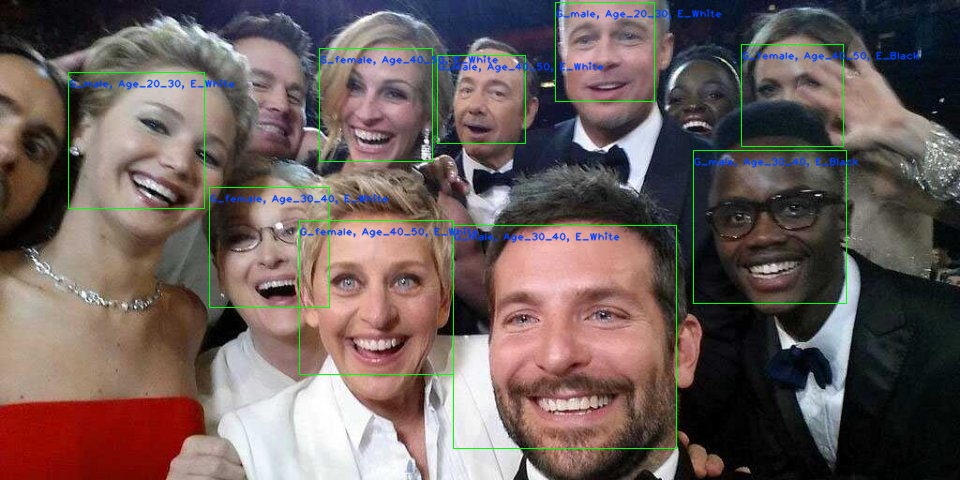

In [185]:
pred_from_file('/test01.jpg')

['G_female, Age_30_40, E_White', 'G_female, Age_30_40, E_White', 'G_female, Age_30_40, E_White', 'G_female, Age_30_40, E_Indian', 'G_male, Age_above50, E_White', 'G_female, Age_40_50, E_Indian']


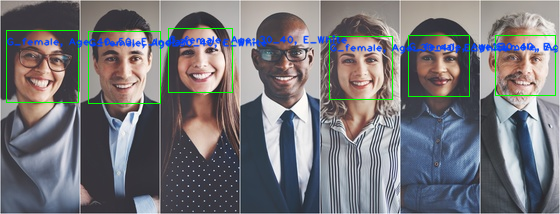

In [188]:
pred_from_file('test02.jpeg')